<a href="https://colab.research.google.com/github/aparnasree2020/CAS_RPM_2023_GBM/blob/main/RPM_XGBoost_Models_AXS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

Here we will install the packages necessary to run this workshop - Part 1
The installation will take about 20 minutes

In [39]:
print("Welcome")

[1] "Welcome"


In [40]:
start_time <- Sys.time()
# Comment after installation so that the whole notebook can be run in one go
install.packages('xgboost')
install.packages('pROC')
install.packages('reshape2')

end_time <- Sys.time()
elapsed_time <- difftime(end_time, start_time, units = "secs")
print(paste("Installation of libraries took: ", round(elapsed_time/60, 2), " minutes"))

#"Installation of libraries took:  11  minutes"




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "Installation of libraries took:  10.51  minutes"


# Load Libraries

In [41]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(pROC)
library(reshape2)

In [42]:
avse.plot.classification <- function(data,var,actual,pred,weight,rt_text,lt_text) {
  header = "Actual vs Predicted"

  home_plot <- data %>%
    mutate(nt = eval(parse(text = var))) %>%
    group_by(nt) %>%
    summarize(  act = sum(eval(parse(text = actual)))
                , pred = sum(eval(parse(text = pred)))
                , exposures = sum(eval(parse(text = weight)))
    ) %>%
    mutate(   actual = act/exposures
              , predicted = pred/exposures)
  
  home_plot <- home_plot[complete.cases(home_plot),]
  
  # off balance for model total prediction
  a1 = paste0("data$",actual)
  a2 = paste0("data$",pred)
  off_balance = sum(eval(parse(text = a1)))/sum(eval(parse(text = a2)))
  home_plot$predicted <- home_plot$predicted*off_balance
  
  par(mar=c(5, 4, 2, 5) + 0.1)
  
  barplot(home_plot$exposures,las=2,col="lightblue",ylim = c(0,max(home_plot$exposures)*1.1))
  par(new=TRUE)
  plot(home_plot$nt, home_plot$actual, col='darkblue',lwd= 4, axes=FALSE, ylim=c(ifelse(min(home_plot$actual)<min(home_plot$predicted),min(home_plot$actual)*0.98,min(home_plot$predicted)*0.98),ifelse(max(home_plot$actual)>max(home_plot$predicted),max(home_plot$actual)*1.02,max(home_plot$predicted)*1.02)), xlab="", ylab="",main=header)
  axis(4, ylim=c(0,1),col="black",las=1)
  axis(1, xlim=c(0,1),col="black",las=1)
  mtext(rt_text,side=4,line=3.0,col="black",font=7)
  mtext(lt_text, side = 2, line=3.0,col="black",font=7)
  box()
  mtext(var,side=1,col="black",line=2.5,font=7) 
  lines(home_plot$nt,home_plot$predicted, col="green",lwd=3)  
}

# Load CSV datafile 
## *  Data split as train and test (80/20 split) and stored in git

*   Train data - Used for model training
*   Test data - Hold out data used for evaluating model performance

In [43]:
data_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_cleaned_data.csv"
full_data <- read.csv(file = data_file, header = TRUE)

In [82]:
set.seed(031311)
sample <- sample(c(TRUE, FALSE), nrow(full_data), replace=TRUE, prob=c(0.8,0.2))
train_data  <- full_data[sample, ]
test_data   <- full_data[!sample, ]

x_train <- train_data[,!names(train_data) %in% "claim_count_pd"]
y_train <- train_data[,names(train_data) %in% "claim_count_pd"]

x_test <- test_data[,!names(test_data) %in% "claim_count_pd"]
y_test <- test_data[,names(test_data) %in% "claim_count_pd"]

In [84]:
nrow(x_train)
ncol(x_train)
nrow(x_test)
ncol(x_test)


[1] 79802

[1] 35

[1] 20198

[1] 35

In case you want to look at the data a bit before we get into the modeling.

In [86]:
colnames(train_data)

[1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "claim_count_pd"              "geo_pop_density_ntile"      
[19] "geo_median_home_value_ntile" "geo_unemployment_pct_ntile" 
[21] "geo_vacant_pct_ntile"        "geo_crime_index_ntile"      
[23] "geo_bach_pct_ntile"          "prior_claim_freq_bi"        
[25] "prior_claim_freq_pd"         "prior_claim_freq_med"       
[27] "prior_claim_freq_pip"        "prior_claim_freq_um"        
[29] "prior_claim_freq_uim"        "prior_claim_freq_coll"      
[31] "prior_claim_freq_comp"       "prior_claim_freq_tot"       
[33] "AAM"                         "NOO"                        
[35] "LOO"                         "est_current_odo"

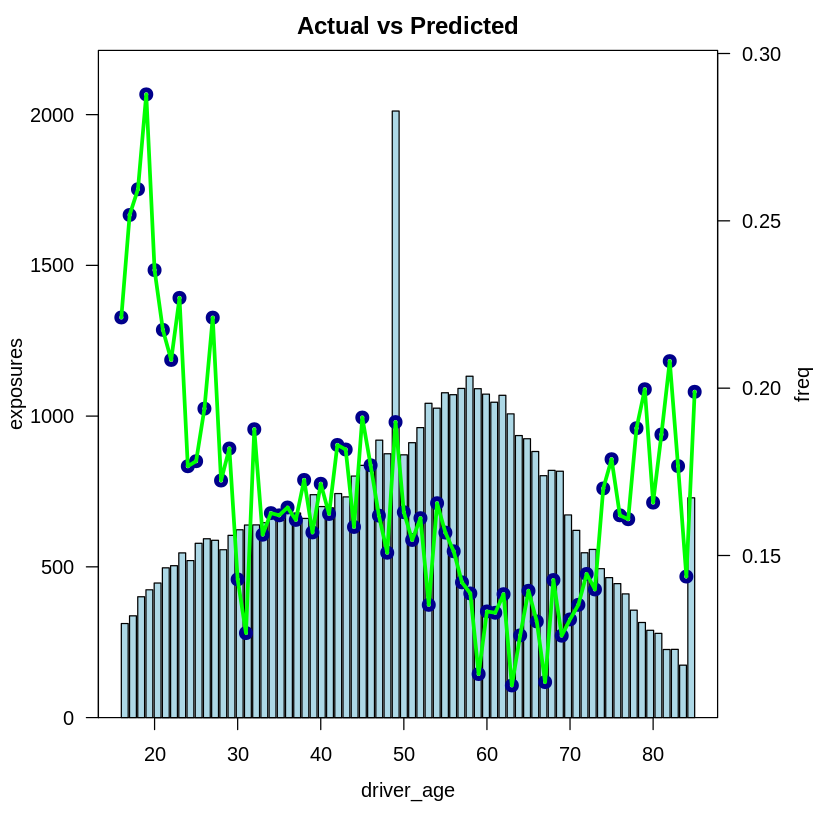

In [87]:
# train_data$nt <- ntile(train_data$LOO, 10)
avse.plot.classification(var="driver_age",data=train_data,actual="claim_count_pd",pred="claim_count_pd",weight="ee_pd",lt_text="exposures",rt_text="freq")

# Fit a standard GLM 

In [88]:
# Set up a place to collect predictions (and a classification from each model)
df_train_pred <- data.frame(y_train)
df_test_pred <- data.frame(y_test)
df_train_pred_bin <- data.frame(y_train)
df_test_pred_bin <- data.frame(y_test)

In [89]:
# Fit a GLM
fit <- step(glm(y_train ~ ., data = x_train, family = "binomial"), direction = "both", trace = FALSE)
df_train_pred$pred_y_GLM_init <- predict(fit, newdata = x_train, type = "response")
df_test_pred$pred_y_GLM_init <- predict(fit, newdata = x_test, type = "response")
df_train_pred_bin$pred_y_GLM_init <- ifelse(df_train_pred$pred_y_GLM_init > 0.1, 1, 0)
df_test_pred_bin$pred_y_GLM_init <- ifelse(df_test_pred$pred_y_GLM_init > 0.1, 1, 0)

In [90]:
df.tmp.train <- data.frame(x_train, df_train_pred)
df.tmp.test <- data.frame(x_test, df_test_pred)

In [91]:
# Let's build prediction bands for lift table review
df.tmp.train <- df.tmp.train %>%
  mutate(freq_nt = ntile(pred_y_GLM_init/ee_pd,10))
df.tmp.test <- df.tmp.test %>%
  mutate(freq_nt = ntile(pred_y_GLM_init/ee_pd,10))

In [92]:
# Get list of variables to make the function call below easier
colnames(df.tmp.train)

[1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_tot"        "AAM"                        
[33] "NOO"                         "LOO"                        
[35] "est_current_odo"             "y_train"                    
[37] "pred_y_GLM_init"             "freq_nt"

In [93]:
# in case you need to bin for viewing - we'll use a single column repeatedly for this purpose rather than bloating the file
var.group = "est_current_odo"
df.tmp.train <- df.tmp.train %>%
  mutate(nt = ntile(eval(parse(text = var.group)), 10))
df.tmp.test <- df.tmp.test %>%
  mutate(nt = ntile(eval(parse(text = var.group)), 10))

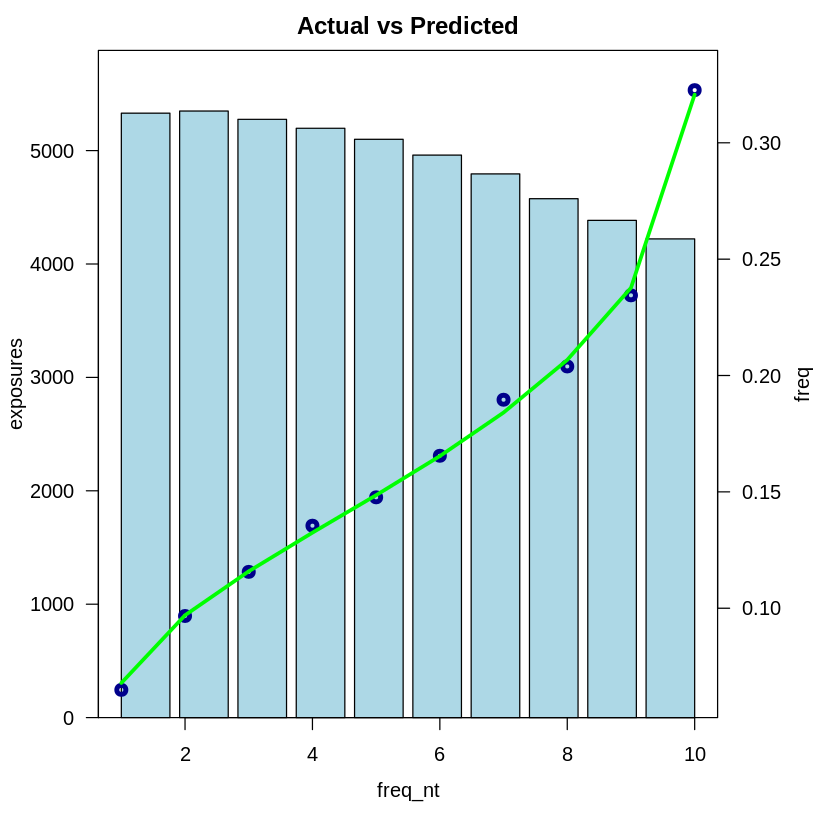

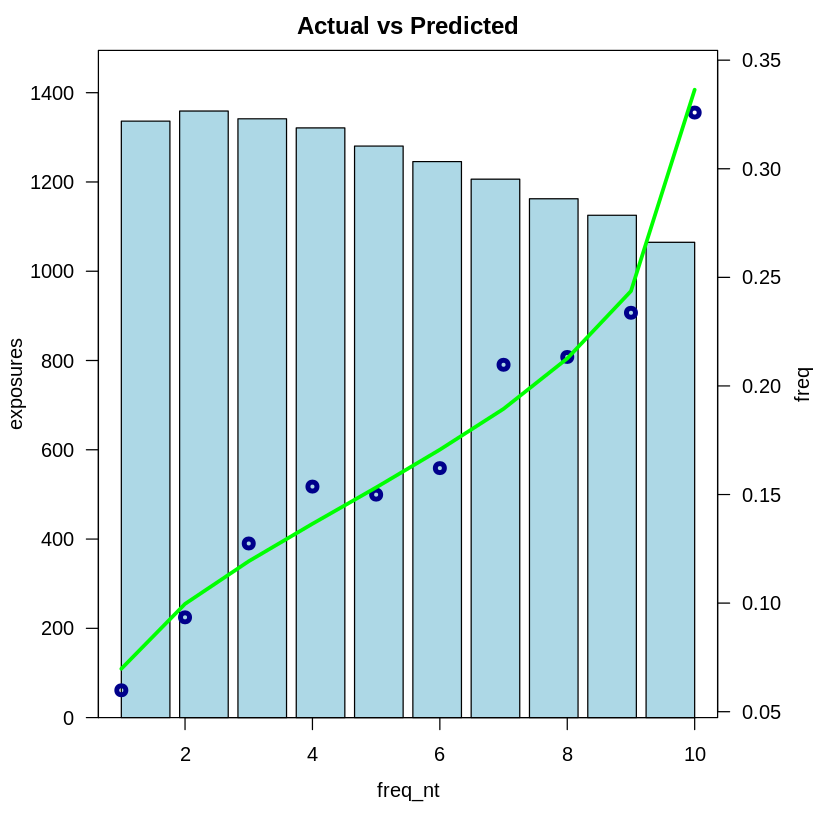

In [94]:
var.curr = "freq_nt"
avse.plot.classification(var=var.curr,data=df.tmp.train,actual="y_train",pred="pred_y_GLM_init",weight="ee_pd",lt_text="exposures",rt_text="freq")
avse.plot.classification(var=var.curr,data=df.tmp.test,actual="y_test",pred="pred_y_GLM_init",weight="ee_pd",lt_text="exposures",rt_text="freq")



#XGboost with essential hyperparameters 

All features are used for this fit

In [95]:
print(colnames(x_train))

 [1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_to

Convert data to XGB format

In [96]:
dtrain <- xgb.DMatrix(data = as.matrix(x_train)
                        , label = y_train
  )
dtest <- xgb.DMatrix(data = as.matrix(x_test)
                       , label = y_test
  )


## Explanation of Weights

*   The XGboost has a feature "scale_pos_weight" which is a hyperparameter in XGBoost that adjusts the weight of positive samples relative to negative samples in imbalanced datasets. It is defined as the ratio of the number of negative samples to the number of positive samples and is used to help the model learn more from the minority class.

*    This is an important hyper parameter, especially for classification task with unbalanced dataset. 
---

## Explanation of AUC 
* XGboost has aother feature "eval_metric = "auc", AUC stands for Area Under the Curve and is a measure of the performance of a binary classifier. It represents the degree or measure of separability between the true positive rate (TPR) and the false positive rate (FPR). AUC ranges from 0 to 1, where an AUC of 1 indicates perfect classification performance, and an AUC of 0.5 indicates a random classification. AUC is commonly used to compare the performance of different models, and it is considered a more reliable measure than accuracy in imbalanced datasets.

---
## Explanation of eta ( also known as learning rate)  
The learning rate controls the magnitude of the updates to the model weights during training. A smaller learning rate means that the model makes smaller updates to the weights at each iteration, which can result in slower convergence but can also help prevent overfitting. On the other hand, a larger learning rate can lead to faster convergence but may also result in overfitting or instability.
* The learning rate is also multiplied by a shrinkage factor (denoted by the parameter lambda or alpha) to further control the magnitude of the updates. The idea is to have a larger learning rate in the beginning of the optimization. As you get closer to the global minima, the idea is to reduce the learning rate. 

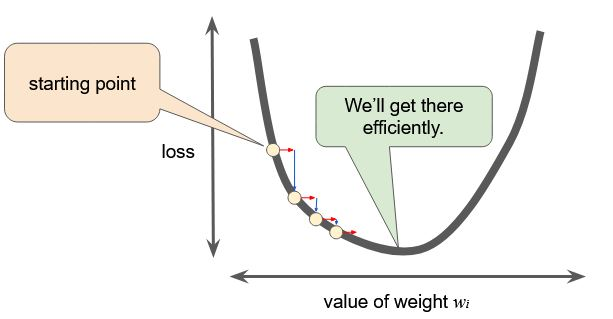

Reference 
https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate 

In [98]:
# First, a simple GBM
fit <- xgboost(data = dtrain,
               nrounds = 100,
               objective = "binary:logistic",
               eta = 0.5,
               max_depth = 9,
               eval_metric = "auc",
               verbose = 0)

df_train_pred$pred_y_XGB_init <- predict(fit, dtrain)
df_test_pred$pred_y_XGB_init <- predict(fit, dtest)
df_train_pred_bin$pred_y_XGB_init <- ifelse(df_train_pred$pred_y_XGB_init > 0.1, 1, 0)
df_test_pred_bin$pred_y_XGB_init <- ifelse(df_test_pred$pred_y_XGB_init > 0.1, 1, 0)

In [99]:
head(df_test_pred)

,y_test,pred_y_GLM_init,pred_y_XGB_init
,<int>,<dbl>,<dbl>
1,0,0.08428160,0.005090991
2,0,0.08713690,0.070828833
3,0,0.07738991,0.030750779
4,0,0.23896515,0.142143607
5,0,0.25445506,0.001577763
6,0,0.08095667,0.022827698


In [100]:
# Calculate weights based on ratio of classes
pos_weight <- sum(y_train == 0) / sum(y_train == 1)
print(pos_weight)
fit <- xgboost(data = dtrain,
               nrounds = 100,
               objective = "binary:logistic",
               eta = 0.5,
               max_depth = 9,
               eval_metric = "auc",
               scale_pos_weight = pos_weight,
               verbose = 0)

df_train_pred$pred_y_XGB_balanced <- predict(fit, dtrain)
df_test_pred$pred_y_XGB_balanced <- predict(fit, dtest)
df_train_pred_bin$pred_y_XGB_balanced <- ifelse(df_train_pred$pred_y_XGB_balanced > 0.5, 1, 0)
df_test_pred_bin$pred_y_XGB_balanced <- ifelse(df_test_pred$pred_y_XGB_balanced > 0.5, 1, 0)

[1] 8.996493


In [101]:
quiet.setting = TRUE
roc_train <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB_balanced, quiet=quiet.setting)
roc_test <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB_balanced, quiet=quiet.setting)
roc_train
roc_test


Call:
roc.default(response = df_train_pred$y_train, predictor = df_train_pred$pred_y_XGB_balanced,     quiet = quiet.setting)

Data: df_train_pred$pred_y_XGB_balanced in 71819 controls (df_train_pred$y_train 0) < 7983 cases (df_train_pred$y_train 1).
Area under the curve: 0.9968


Call:
roc.default(response = df_test_pred$y_test, predictor = df_test_pred$pred_y_XGB_balanced,     quiet = quiet.setting)

Data: df_test_pred$pred_y_XGB_balanced in 18112 controls (df_test_pred$y_test 0) < 2086 cases (df_test_pred$y_test 1).
Area under the curve: 0.579

### Insights 
Since the AUC here is near 1.0, (we wish) we can consider this to be a good model. But, clearly we're overfitting, per the test data AUC of 0.58. In the interest of time, let's fast forward to choosing a different hyperparameters to improve on the gap.

In [133]:
# First, let's go with some pet hyperparameters
fit <- xgboost(data = dtrain,
               nrounds = 100,
               objective = "binary:logistic",
               eta = 0.1,
               max_depth = 6,
               subsample = 0.6,
               colsample_bytree = 0.6,
               eval_metric = "auc",
               scale_pos_weight = pos_weight,
               verbose = 0)

df_train_pred$pred_y_XGB2 <- predict(fit, dtrain)
df_test_pred$pred_y_XGB2 <- predict(fit, dtest)
df_train_pred_bin$pred_y_XGB2 <- ifelse(df_train_pred$pred_y_XGB2 > 0.5, 1, 0)
df_test_pred_bin$pred_y_XGB2 <- ifelse(df_test_pred$pred_y_XGB2 > 0.5, 1, 0)

In [118]:
quiet.setting = TRUE
roc_train <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB2, quiet=quiet.setting)
roc_test <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB2, quiet=quiet.setting)
roc_train
roc_test


Call:
roc.default(response = df_train_pred$y_train, predictor = df_train_pred$pred_y_XGB2,     quiet = quiet.setting)

Data: df_train_pred$pred_y_XGB2 in 71819 controls (df_train_pred$y_train 0) < 7983 cases (df_train_pred$y_train 1).
Area under the curve: 0.775


Call:
roc.default(response = df_test_pred$y_test, predictor = df_test_pred$pred_y_XGB2,     quiet = quiet.setting)

Data: df_test_pred$pred_y_XGB2 in 18112 controls (df_test_pred$y_test 0) < 2086 cases (df_test_pred$y_test 1).
Area under the curve: 0.6524

## Importance matrix

The importance matrix in XGBoost is a tool that helps to measure the relative importance of each feature in the model. It is calculated based on the contribution of each feature to the reduction of the loss function during training. There are two types of importance matrices in XGBoost: weight-based and gain-based. The importance matrix can be used for feature selection or dimensionality reduction, and it can be visualized using a bar chart or heatmap to make it easier to interpret the results.

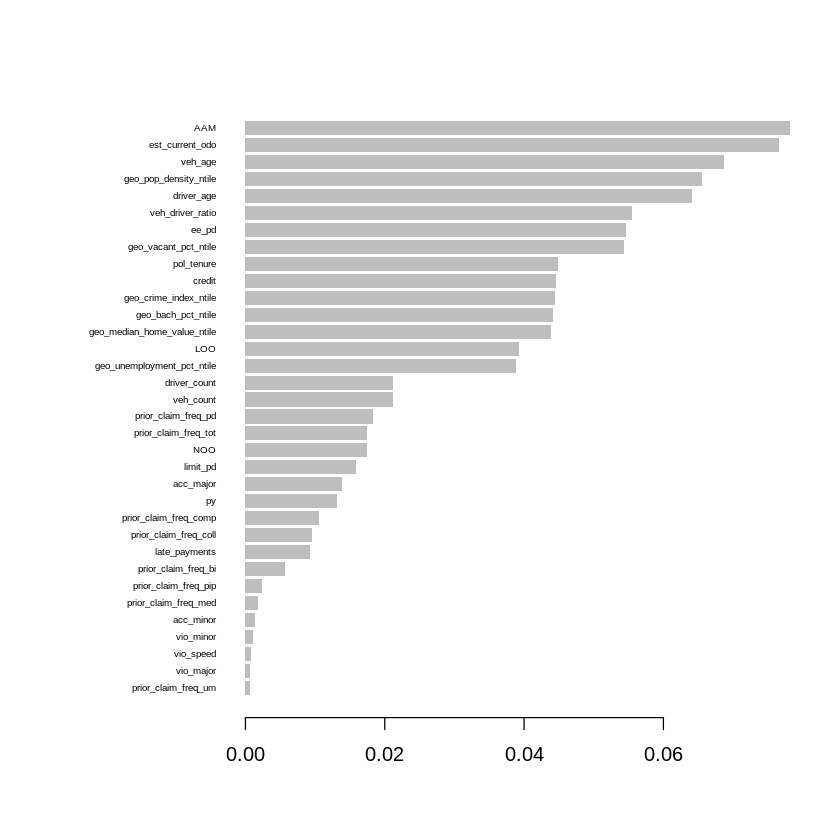

In [134]:
importance_matrix <- xgb.importance(colnames(dtrain), model = fit)
importance_matrix <- subset(importance_matrix, select = c(Feature,Gain))
  
xgb.plot.importance(importance_matrix) 
top_15_features <- head(importance_matrix$Feature, 15)

In [135]:
print(top_15_features)

 [1] "AAM"                         "est_current_odo"            
 [3] "veh_age"                     "geo_pop_density_ntile"      
 [5] "driver_age"                  "veh_driver_ratio"           
 [7] "ee_pd"                       "geo_vacant_pct_ntile"       
 [9] "pol_tenure"                  "credit"                     
[11] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[13] "geo_median_home_value_ntile" "LOO"                        
[15] "geo_unemployment_pct_ntile" 


In [136]:
df.tmp.train <- data.frame(x_train, df_train_pred)
df.tmp.test <- data.frame(x_test, df_test_pred)
colnames(df.tmp.train)

[1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_tot"        "AAM"                        
[33] "NOO"                         "LOO"                        
[35] "est_current_odo"             "y_train"                    
[37] "pred_y_GLM_init"             "pred_y_XGB_init"            
[39] "pred_y_XGB_balanced"         "pred_y_XGB2"                
[41] "pred_y_GLM2"

In [137]:
# Let's build prediction bands for lift table review
df.tmp.train <- df.tmp.train %>%
  mutate(freq_nt = ntile(pred_y_XGB2/ee_pd,10))
df.tmp.test <- df.tmp.test %>%
  mutate(freq_nt = ntile(pred_y_XGB2/ee_pd,10))

In [138]:
# Again, in case we need variable binning
var.group = "freq_nt"
df.tmp.train <- df.tmp.train %>%
  mutate(nt = ntile(eval(parse(text = var.group)), 10))
df.tmp.test <- df.tmp.test %>%
  mutate(nt = ntile(eval(parse(text = var.group)), 10))

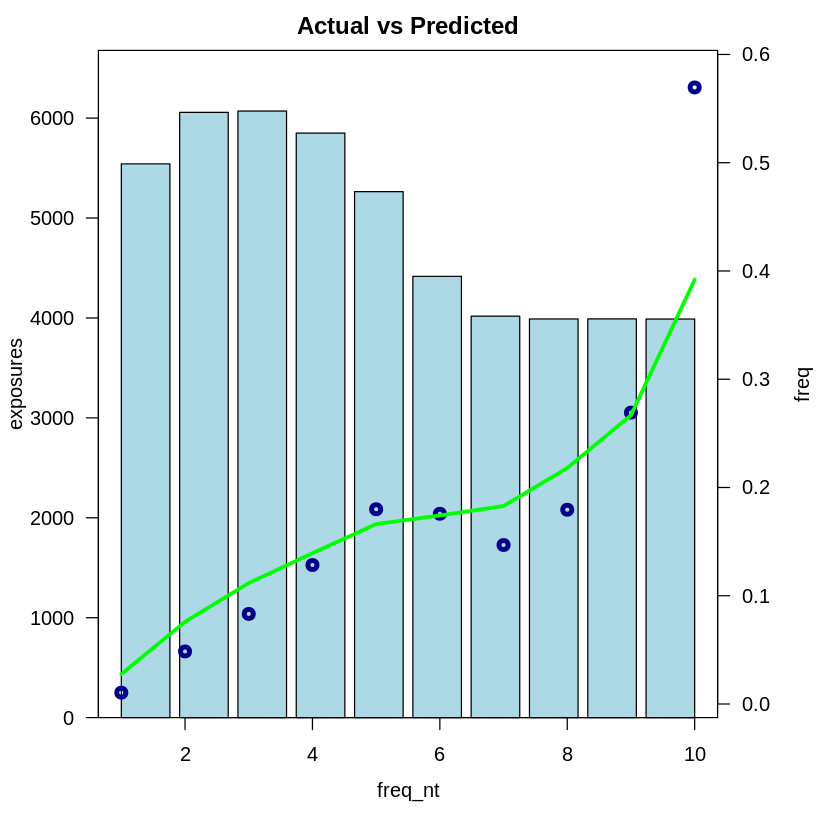

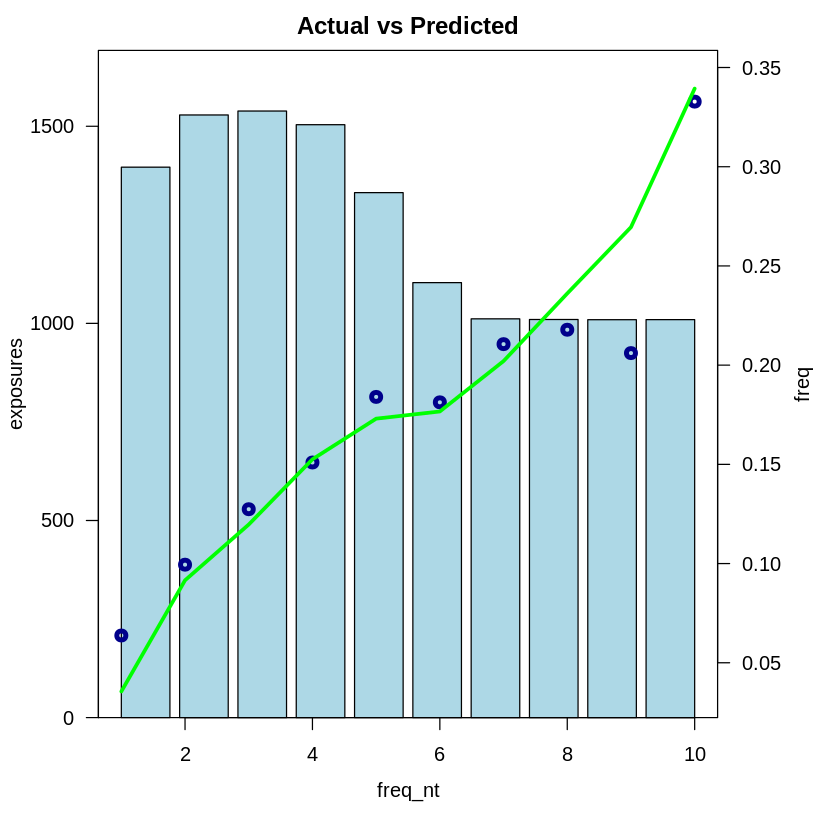

In [139]:
var.curr = "freq_nt"
avse.plot.classification(var=var.curr,data=df.tmp.train,actual="y_train",pred="pred_y_XGB_balanced",weight="ee_pd",lt_text="exposures",rt_text="freq")
avse.plot.classification(var=var.curr,data=df.tmp.test,actual="y_test",pred="pred_y_XGB_balanced",weight="ee_pd",lt_text="exposures",rt_text="freq")

### Improving GLM using XGboost insights 

In this secion, we will try to improve the GLM output based on results from Xgboost. 


1. Reduce number of features based on XGboost ( feature selection) 
2. Use appropriate weight function and evaluation metric ( AUC) 




In [140]:
x_train_top15 <- x_train[, c(top_15_features)]
x_test_top15 <- x_test[, c(top_15_features)]
#print(x_train)



In [141]:
head(x_test_top15)

,AAM,est_current_odo,veh_age,geo_pop_density_ntile,driver_age,veh_driver_ratio,ee_pd,geo_vacant_pct_ntile,pol_tenure,credit,geo_crime_index_ntile,geo_bach_pct_ntile,geo_median_home_value_ntile,LOO,geo_unemployment_pct_ntile
,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>
19,17178.00,116354.1,12,7,53,0.5,0.498,48,3,1,79,45,36,5,52
20,12954.84,86757.0,6,19,57,1.5,0.504,61,2,10,82,8,15,0,15
27,4897.00,204271.0,15,26,49,1.5,0.498,71,0,5,89,16,1,2,3
46,12954.84,116354.1,12,43,34,0.5,0.504,22,2,9,11,96,66,2,16
47,20428.00,97990.0,5,32,42,0.5,0.999,84,3,9,48,85,73,3,32
53,12954.84,116354.1,13,49,49,2.0,0.504,71,0,5,17,94,83,0,5


In [142]:
# Fit a GLM
fit <- glm(y_train ~ ., data = x_train_top15, family = "binomial")
df_train_pred$pred_y_GLM2 <- predict(fit, newdata = x_train_top15, type = "response")
df_test_pred$pred_y_GLM2 <- predict(fit, newdata = x_test_top15, type = "response")
df_train_pred_bin$pred_y_GLM2 <- ifelse(df_train_pred$pred_y_GLM2 > 0.1, 1, 0)
df_test_pred_bin$pred_y_GLM2 <- ifelse(df_test_pred$pred_y_GLM2 > 0.1, 1, 0)

Introduce Exposure as a "base_margin"

In [148]:
x_train2 <- x_train[, -which(names(x_train) == "ee_pd")]
x_test2 <- x_test[, -which(names(x_test) == "ee_pd")]

dtrain_exp <- xgb.DMatrix(data = as.matrix(x_train2)
                        , label = y_train
  )
setinfo(dtrain_exp, "base_margin", log(x_train$ee_pd))

dtest_exp <- xgb.DMatrix(data = as.matrix(x_test2)
                       , label = y_test
  )
setinfo(dtest_exp, "base_margin", log(x_test$ee_pd))

[1] TRUE

[1] TRUE

In [159]:
# First, a simple GBM
fit <- xgboost(data = dtrain_exp,
               nrounds = 100,
               objective = "binary:logistic",
               eta = 0.1,
               max_depth = 6,
               subsample = 0.6,
               colsample_bytree = 0.6,
               eval_metric = "auc",
               scale_pos_weight = pos_weight,
               verbose = 0)

df_train_pred$pred_y_XGB3 <- predict(fit, dtrain_exp)
df_test_pred$pred_y_XGB3 <- predict(fit, dtest_exp)
df_train_pred_bin$pred_y_XGB3 <- ifelse(df_train_pred$pred_y_XGB3 > 0.5, 1, 0)
df_test_pred_bin$pred_y_XGB3 <- ifelse(df_test_pred$pred_y_XGB3 > 0.5, 1, 0)

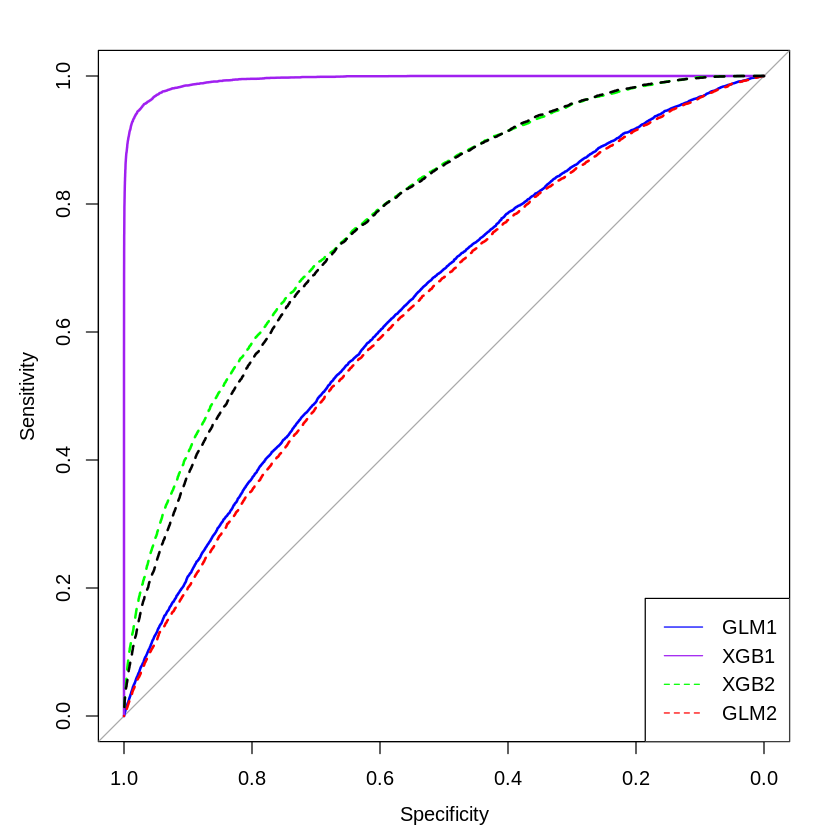

In [165]:
# Create a ROC curve for training data
quiet.setting = TRUE
roc_curve1 <- roc(df_train_pred$y_train, df_train_pred$pred_y_GLM_init, quiet=quiet.setting)
roc_curve2 <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB_init, quiet=quiet.setting)
roc_curve3 <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB2, quiet=quiet.setting)
roc_curve4 <- roc(df_train_pred$y_train, df_train_pred$pred_y_GLM2, quiet=quiet.setting)
roc_curve5 <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB3, quiet=quiet.setting)


plot(roc_curve1, col = "blue", type="l", lty=1)
lines(roc_curve2, col = "purple", lty=1)
lines(roc_curve3, col = "green", lty=2)
lines(roc_curve4, col = "red", lty=2)
lines(roc_curve5, col = "black", lty=2)

# Add a legend
legend("bottomright", legend = c("GLM1", "XGB1", "XGB2", "GLM2"),
       col = c("blue", "purple","green", "red"), lty = c(1, 1, 2, 2))

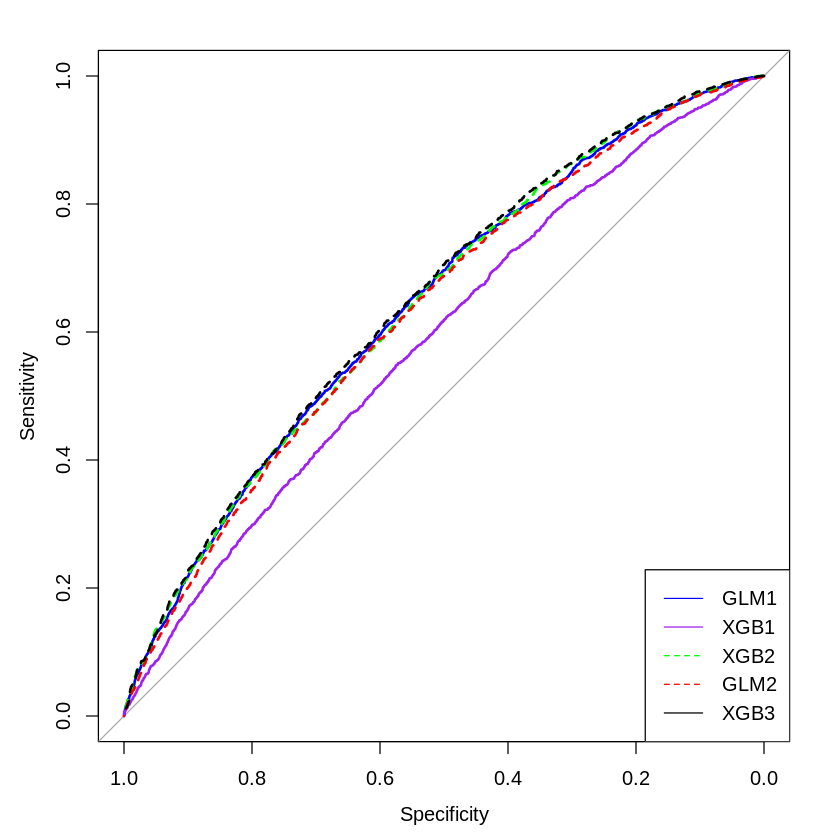

In [161]:
# Create a ROC curve
quiet.setting = TRUE
roc_curve1 <- roc(df_test_pred$y_test, df_test_pred$pred_y_GLM_init, quiet=quiet.setting)
roc_curve2 <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB_init, quiet=quiet.setting)
roc_curve3 <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB2, quiet=quiet.setting)
roc_curve4 <- roc(df_test_pred$y_test, df_test_pred$pred_y_GLM2, quiet=quiet.setting)
roc_curve5 <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB3, quiet=quiet.setting)

plot(roc_curve1, col = "blue", type="l", lty=1)
lines(roc_curve2, col = "purple", lty=1)
lines(roc_curve3, col = "green", lty=2)
lines(roc_curve4, col = "red", lty=2)
lines(roc_curve5, col = "black", lty=2)
# Add a legend
legend("bottomright", legend = c("GLM1", "XGB1", "XGB2", "GLM2","XGB3"),
       col = c("blue", "purple","green", "red","black"), lty = c(1, 1, 2, 2))

Our statline builder, to make things a little easier

In [169]:
quiet.setting = TRUE
model_names <- c("GLM_init", "XGB_init", "XGB2", "GLM2", "XGB3")

auc_GLM_init <- auc(df_train_pred$y_train, df_train_pred$pred_y_GLM_init, quiet=quiet.setting)
auc_XGB_init <- auc(df_train_pred$y_train, df_train_pred$pred_y_XGB_init, quiet=quiet.setting)
auc_XGB2 <- auc(df_train_pred$y_train, df_train_pred$pred_y_XGB2, quiet=quiet.setting)
auc_GLM2 <- auc(df_train_pred$y_train, df_train_pred$pred_y_GLM2, quiet=quiet.setting)
auc_XGB3 <- auc(df_train_pred$y_train, df_train_pred$pred_y_XGB3, quiet=quiet.setting)

auc_train <- c(auc_GLM_init, auc_XGB_init, auc_XGB2, auc_GLM2,auc_XGB3)
gini_train <- 2 * auc_train - 1

auc_GLM_init <- auc(df_test_pred$y_test, df_test_pred$pred_y_GLM_init, quiet=quiet.setting)
auc_XGB_init <- auc(df_test_pred$y_test, df_test_pred$pred_y_XGB_init, quiet=quiet.setting)
auc_XGB2 <- auc(df_test_pred$y_test, df_test_pred$pred_y_XGB2, quiet=quiet.setting)
auc_GLM2 <- auc(df_test_pred$y_test, df_test_pred$pred_y_GLM2, quiet=quiet.setting)
auc_XGB3 <- auc(df_test_pred$y_test, df_test_pred$pred_y_XGB3, quiet=quiet.setting)

auc_test <- c(auc_GLM_init, auc_XGB_init, auc_XGB2, auc_GLM2, auc_XGB3)
gini_test <- 2 * auc_test - 1

data.frame(model_names, auc_train, gini_train, auc_test, gini_test)

model_names,auc_train,gini_train,auc_test,gini_test
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GLM_init,0.6436672,0.2873343,0.6418490,0.2836979
XGB_init,0.9945597,0.9891194,0.5884336,0.1768672
XGB2,0.7779400,0.5558801,0.6421028,0.2842056
GLM2,0.6341344,0.2682687,0.6334891,0.2669781
XGB3,0.7690017,0.5380034,0.6486078,0.2972157


ERROR: ignored

In [163]:
end_time <- Sys.time()
elapsed_time <- difftime(end_time, start_time, units = "secs")
print(paste("Full Notebook Run took: ", round(elapsed_time/60, 2), " minutes"))


[1] "Full Notebook Run took:  94.13  minutes"



We can now work to move GLM toward XGB, or improve on XGB knowing we still have a gap between train and test.

As for today, we will pause, and go for break. When we return, we will provide another case study.

# END